## Calculating Tree Count (small and large) and carbon displacement for all six sites — Connected Components Using A Green Mask

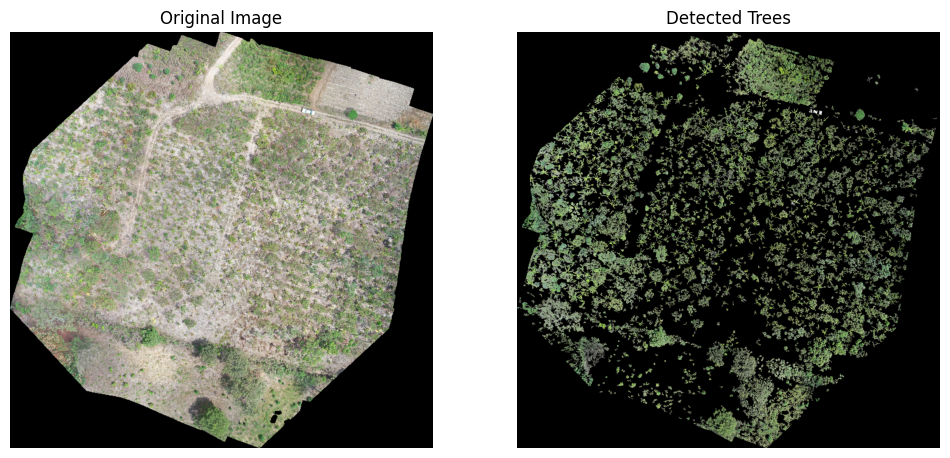

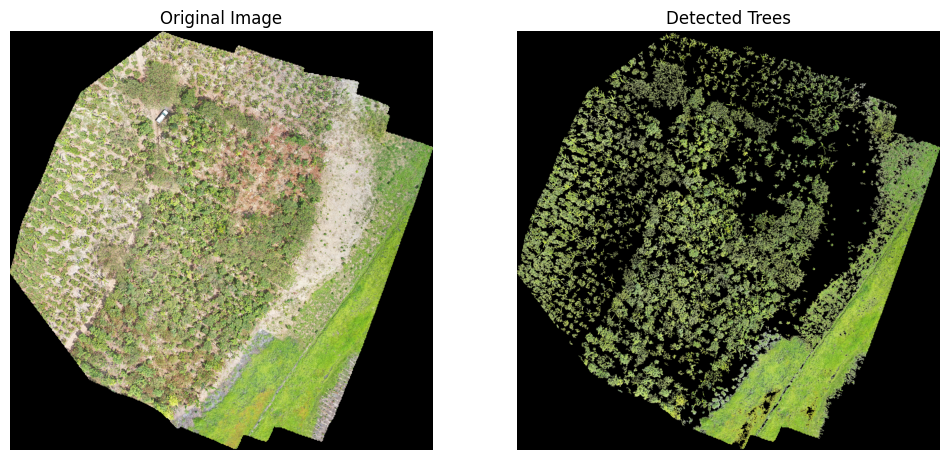

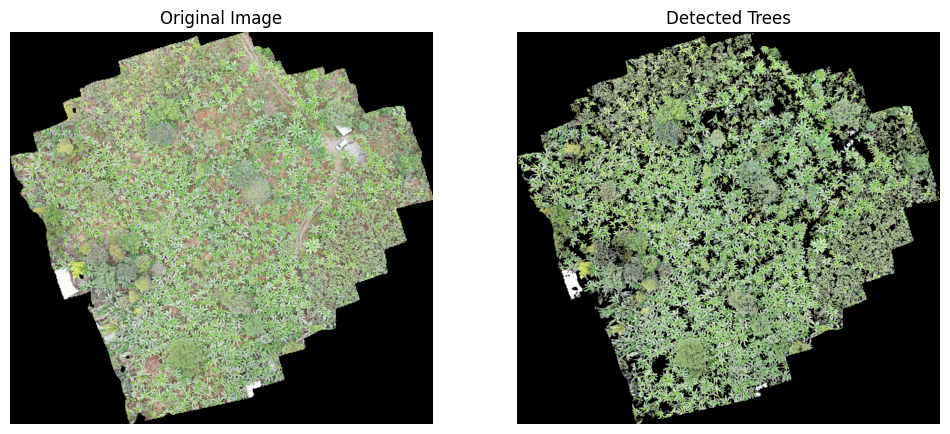

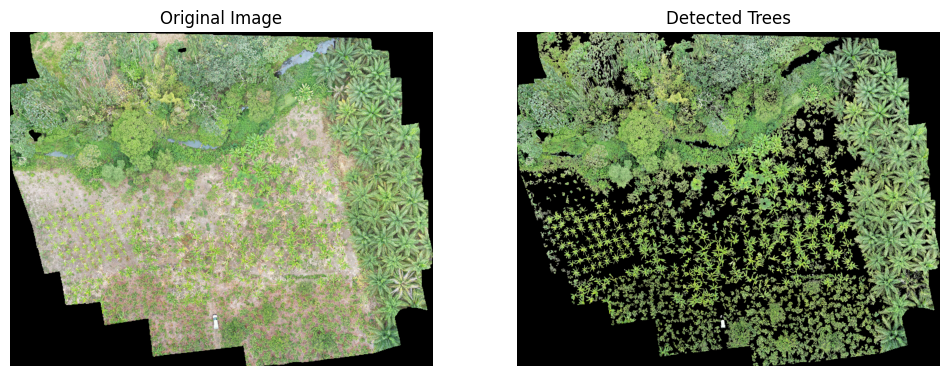

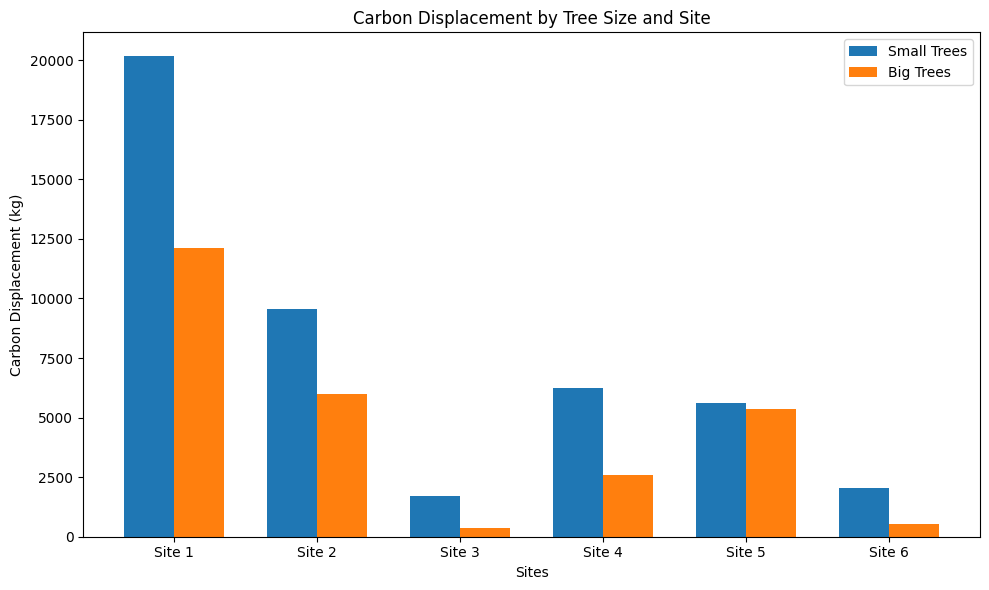

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def analyze_tree_sizes_and_carbon(image_path, green_threshold=0.4, min_area_small=100, min_area_big=500, resize_factor=0.2):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Resize the image to speed up processing
    if resize_factor < 1.0:
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)

    # Normalize pixel values to 0-1
    normalized_image = image / 255.0

    # Extract R, G, B channels
    red_channel = normalized_image[:, :, 0]
    green_channel = normalized_image[:, :, 1]
    blue_channel = normalized_image[:, :, 2]

    # Define "greenest" pixels
    green_mask = (green_channel > green_threshold) & (green_channel > red_channel) & (green_channel > blue_channel)

    # Find connected components in the green mask
    num_labels, labels = cv2.connectedComponents(green_mask.astype(np.uint8))

    # Filter components into small and big trees
    small_tree_count = 0
    big_tree_count = 0
    total_carbon_small = 0
    total_carbon_big = 0

    for i in range(1, num_labels):  # Skip the background label
        area = np.sum(labels == i)
        if area >= min_area_small and area < min_area_big:
            small_tree_count += 1
            total_carbon_small += 22.6
        elif area >= min_area_big:
            big_tree_count += 1
            total_carbon_big += 22.6 * 1.5

    # Create the result image with trees highlighted
    tree_mask = np.isin(labels, [i for i in range(1, num_labels) if np.sum(labels == i) >= min_area_small])
    result_image = image.copy()
    result_image[~tree_mask] = [0, 0, 0]  # Set non-tree pixels to black

    # Show the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Detected Trees")
    plt.imshow(result_image)
    plt.axis("off")
    plt.show()

    # Return the counts and carbon displacement
    return small_tree_count, big_tree_count, total_carbon_small, total_carbon_big

# Process multiple sites
sites = [
    "data/wwf_ecuador/RGB Orthomosaics/Carlos Vera Arteaga RGB.tif",
    "data/wwf_ecuador/RGB Orthomosaics/Carlos Vera Guevara RGB.tif",
    "data/wwf_ecuador/RGB Orthomosaics/Flora Pluas RGB.tif",
    "data/wwf_ecuador/RGB Orthomosaics/Leonor Aspiazu RGB.tif",
    "data/wwf_ecuador/RGB Orthomosaics/Manuel Macias RGB.tif",
    "data/wwf_ecuador/RGB Orthomosaics/Nestor Macias RGB.tif"
]

site_results = []
for site in sites:
    small_trees, big_trees, carbon_small, carbon_big = analyze_tree_sizes_and_carbon(site)
    site_results.append((small_trees, big_trees, carbon_small, carbon_big))

# Create a bar graph
labels = [f"Site {i+1}" for i in range(len(sites))]
small_tree_carbon = [result[2] for result in site_results]
big_tree_carbon = [result[3] for result in site_results]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, small_tree_carbon, width, label='Small Trees')
ax.bar(x + width/2, big_tree_carbon, width, label='Big Trees')

# Add labels, title, and legend
ax.set_xlabel('Sites')
ax.set_ylabel('Carbon Displacement (kg)')
ax.set_title('Carbon Displacement by Tree Size and Site')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


Based on the image — was suspicious about inconsistencies with the number of trees detected and a missmatch with the count from before. This was validated by a quick check. 

In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def identify_green_regions_and_detect_trees(image_path, green_threshold=0.4, min_area=100, resize_factor=0.2):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB format

    # Resize the image to speed up processing
    if resize_factor < 1.0:
        image = cv2.resize(image, (0, 0), fx=resize_factor, fy=resize_factor)

    # Normalize pixel values to 0-1
    normalized_image = image / 255.0

    # Extract R, G, B channels
    red_channel = normalized_image[:, :, 0]
    green_channel = normalized_image[:, :, 1]
    blue_channel = normalized_image[:, :, 2]

    # Define "greenest" pixels using numpy vectorized operations
    green_mask = (green_channel > green_threshold) & (green_channel > red_channel) & (green_channel > blue_channel)

    # Find connected components in the green mask
    num_labels, labels = cv2.connectedComponents(green_mask.astype(np.uint8))

    # Filter out small components based on area (to avoid noise)
    sizes = [np.sum(labels == i) for i in range(num_labels)]
    large_components = [i for i, size in enumerate(sizes) if size > min_area]

    # Return the number of large connected components (trees detected)
    return len(large_components)

# Step 1: Read the CSV data
df = pd.read_csv('data/annotations/cleaned/clean_annotations.csv')

# List of image names corresponding to each site
sites = [
    "Carlos Vera Arteaga RGB",
    "Carlos Vera Guevara RGB",
    "Flora Pluas RGB",
    "Leonor Aspiazu RGB",
    "Manuel Macias RGB",
    "Nestor Macias RGB"
]

# Initialize lists to store the results
connected_component_counts = []
csv_tree_counts = []

# Step 2: Process each site image and compare tree counts
for img_name in sites:
    # Step 2.1: Filter the data for the specific image
    img_data = df[df['img_name'] == img_name]
    csv_tree_count = img_data.shape[0]  # Tree count from CSV
    csv_tree_counts.append(csv_tree_count)

    # Step 2.2: Load and process the image
    image_path = f"data/wwf_ecuador/RGB Orthomosaics/{img_name}.tif"
    detected_tree_count = identify_green_regions_and_detect_trees(image_path)

    # Store the detected tree count
    connected_component_counts.append(detected_tree_count)

# Step 3: Create a bar graph comparing the two counts
x = np.arange(len(sites))  # Label locations

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 0.2, connected_component_counts, 0.4, label='Detected Trees (Connected Components)')
ax.bar(x + 0.2, csv_tree_counts, 0.4, label='Tree Count from DeepForest')

# Add labels, title, and legend
ax.set_xlabel('Sites')
ax.set_ylabel('Number of Trees')
ax.set_title('Comparison of Detected Trees vs. Tree Count from DeepForest')
ax.set_xticks(x)
ax.set_xticklabels([f"Site {i+1}" for i in range(len(sites))])
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()